In [1]:
import torch
from utils.dataset import get_data_loaders
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose
import torch
import os
from utils.dataset import get_data_loaders
from models.CNN import CNN
from tqdm import tqdm
from utils.dataset import get_data_loaders
from models.CNN import CNN
import pickle

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is NOT available. Using CPU.")

hydra.core.global_hydra.GlobalHydra.instance().clear()
with initialize(version_base=None, config_path="../src/configs"):
    cfg = compose(config_name="base", overrides=["project_root=/home/paperspace/DeepEmotion"])
print(cfg)

CUDA is available. Using GPU: Quadro M4000
{'project_root': '/home/paperspace/DeepEmotion', 'verbose': True, 'wandb': True, 'sys_log': True, 'model': 'CNN', 'CNN': {'c1': 16, 'c2': 32, 'c3': 64, 'k1': 3, 'k2': 3, 'k3': 3, 'pk': 2, 'ps': 2, 'kernel_size': 3, 'stride': 1, 'padding': 1}, 'train': {'epochs': 50, 'batch_size': 2, 'shuffle': True, 'train_ratio': 0.8, 'print_label_frequencies': True}, 'data': {'data_path': '${project_root}/data/raw/derivatives/non-linear_anatomical_alignment', 'zarr_dir_path': '${project_root}/zarr_datasets', 'zarr_path': '${project_root}/zarr_datasets/pool_emotions', 'label_path': '${project_root}/data/updated_annotations/pooled_annotations_structured.tsv', 'sessions': ['02'], 'file_pattern_template': '*_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNL_run-{}_bold.nii.gz', 'subjects': ['sub-01'], 'session_offsets': [0, 902, 1784, 2660, 3636, 4560, 5438, 6522], 'emotion_idx': {'NONE': 0, 'HAPPINESS': 1, 'FEAR': 2, 'SADNESS': 3, 'LOVE': 4, 'ANGER': 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Suppose cfg.data.emotion_idx maps something like { "happy": 0, "sad": 1, ... }
# We'll create a dict to hold a list of gradients for each class:
class_gradients = {
    idx: [] for emotion, idx in cfg.data.emotion_idx.items() if emotion != "NONE"
}

# Config variables
PROJECT_ROOT = os.path.abspath("../")

cfg = OmegaConf.create({
    "project_root": PROJECT_ROOT,
    "verbose": True,
    "wandb": True,
    "sys_log": True,
    "model": "CNN",
    "CNN": {
        "c1": 16, "c2": 32, "c3": 64, "k1": 3, "k2": 3, "k3": 3,
        "pk": 2, "ps": 2, "kernel_size": 3, "stride": 1, "padding": 1
    },
    "train": {
        "epochs": 50, "batch_size": 10, "shuffle": True, "train_ratio": 0.8,
        "print_label_frequencies": True
    },
    "data": {
        "data_path": f"{PROJECT_ROOT}/data/raw/derivatives/non-linear_anatomical_alignment",
        "zarr_dir_path": f"{PROJECT_ROOT}/zarr_datasets",
        "zarr_path": f"{PROJECT_ROOT}/zarr_datasets/pool_emotions",
        "label_path": f"{PROJECT_ROOT}/data/updated_annotations/pooled_annotations_structured.tsv",
        "sessions": ["01", "02", "03", "04", "05", "06", "07", "08"],
        "file_pattern_template": "*_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNL_run-{}_bold.nii.gz",
        "subjects": ["sub-1"],
        "session_offsets": [0, 902, 1784, 2660, 3636, 4560, 5438, 6522],
        "emotion_idx": {"NONE": 0, "HAPPINESS": 1, "FEAR": 2, "SADNESS": 3, "LOVE": 4, "ANGER": 5},
        "normalization": False,
        "weight_decay": 0,
        "learning_rate": 0.0001,
        "seed": 42,
        "save_model": True,
        "load_model": False,
        "save_model_path": "output/models",
        "load_model_path": f"{PROJECT_ROOT}/src/output/models/sub_ALL.pth",
        "output_csv_path": f"{PROJECT_ROOT}/src/output/PCA/hidden/sub_ALL.csv"
    }
})

# Load dataloaders
train_dataloader, val_dataloader = get_data_loaders(cfg)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(cfg=cfg, output_dim=len(cfg.data.emotion_idx))
model.load_state_dict(torch.load(cfg.data.load_model_path, map_location=device))
model.to(device)
model.eval()

for batch_idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    # [B, C, D, H, W] or [B, D, H, W], whichever your model expects
    data = batch["data_tensor"].float().to(device, non_blocking=True)
    labels = batch["label_tensor"].long().to(device, non_blocking=True)

    # We want gradient wrt the input, so mark it as requires_grad
    data.requires_grad_(True)
    
    # Forward pass
    logits = model(data)  # shape [B, num_classes]
    
    for i in range(data.size(0)):
        # Zero out grads for each sample so they don’t accumulate
        model.zero_grad()
        if data.grad is not None:
            data.grad.zero_()
        
        # Identify the true label for sample i
        label_i = labels[i].item()

        # Grad-CAM style usually calls backward on the class score we care about.
        # We'll do exactly that for the ground-truth class:
        logits[i, label_i].backward(retain_graph=True)

        # data.grad now has gradient of that class score wrt the input
        grad_i = data.grad[i].detach().cpu().clone()  # store a copy in CPU memory

        class_gradients[label_i].append(grad_i)

    # Turn off .requires_grad to avoid keeping references around
    data.requires_grad_(False)

# Now class_gradients[k] is a list of per-sample gradients for class k
# You can convert them to a single tensor if desired:
# Remove or skip classes that have no gradient samples
keys_to_remove = []
for k in class_gradients.keys():
    if len(class_gradients[k]) == 0:
        keys_to_remove.append(k)

for k in keys_to_remove:
    del class_gradients[k]

# Now stack the non-empty lists
for k in class_gradients.keys():
    class_gradients[k] = torch.stack(class_gradients[k])

# At this point, `class_gradients` is a dictionary of tensors you can use or save.
# Each key is the class index, and each value is a tensor of that class’s gradients.

output_path = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"

# Make sure the directory exists
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save the dictionary
with open(output_path, 'wb') as f:
    pickle.dump(class_gradients, f)

Dataset contains 1 files.
Spatial dimensions: (132, 175, 48)
Maximum timepoints per file: 441
Subjects: ['sub-01']
Sessions: ['02']
Emotion categories: ['NONE', 'HAPPINESS', 'FEAR', 'SADNESS', 'LOVE', 'ANGER']
Total valid labeled timepoints: 34


  0%|          | 0/3 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 678.00 MiB. GPU 0 has a total capacity of 7.92 GiB of which 624.31 MiB is free. Process 3984 has 4.81 GiB memory in use. Including non-PyTorch memory, this process has 2.50 GiB memory in use. Of the allocated memory 2.35 GiB is allocated by PyTorch, and 60.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

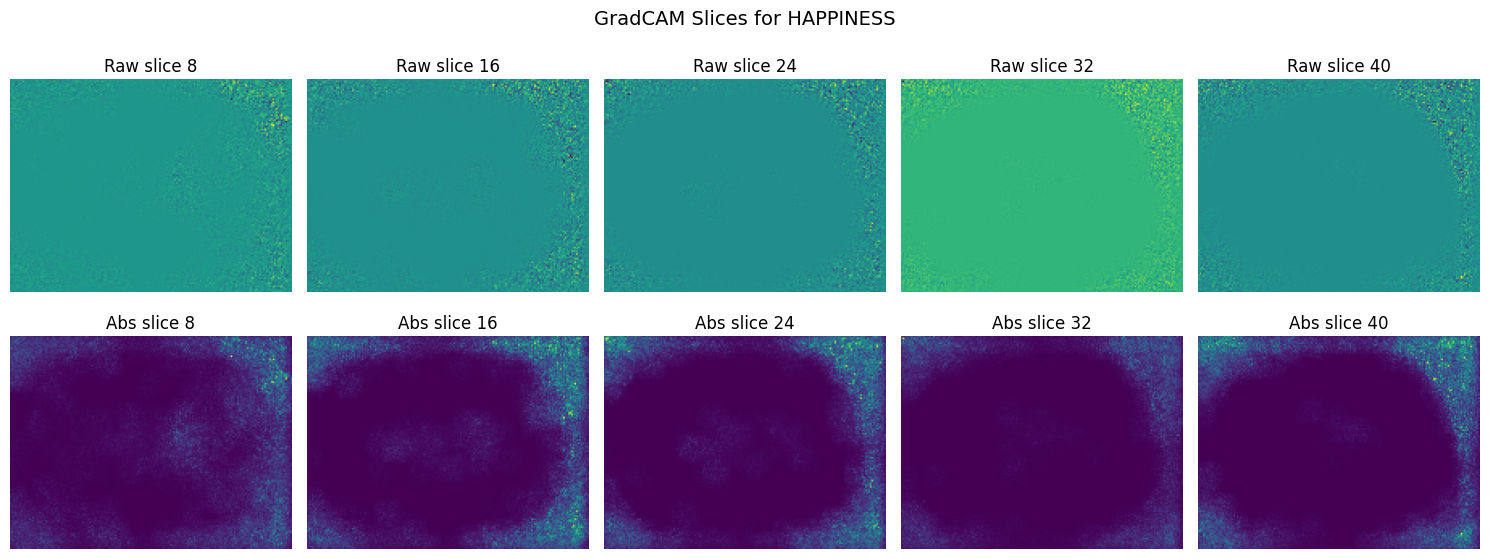

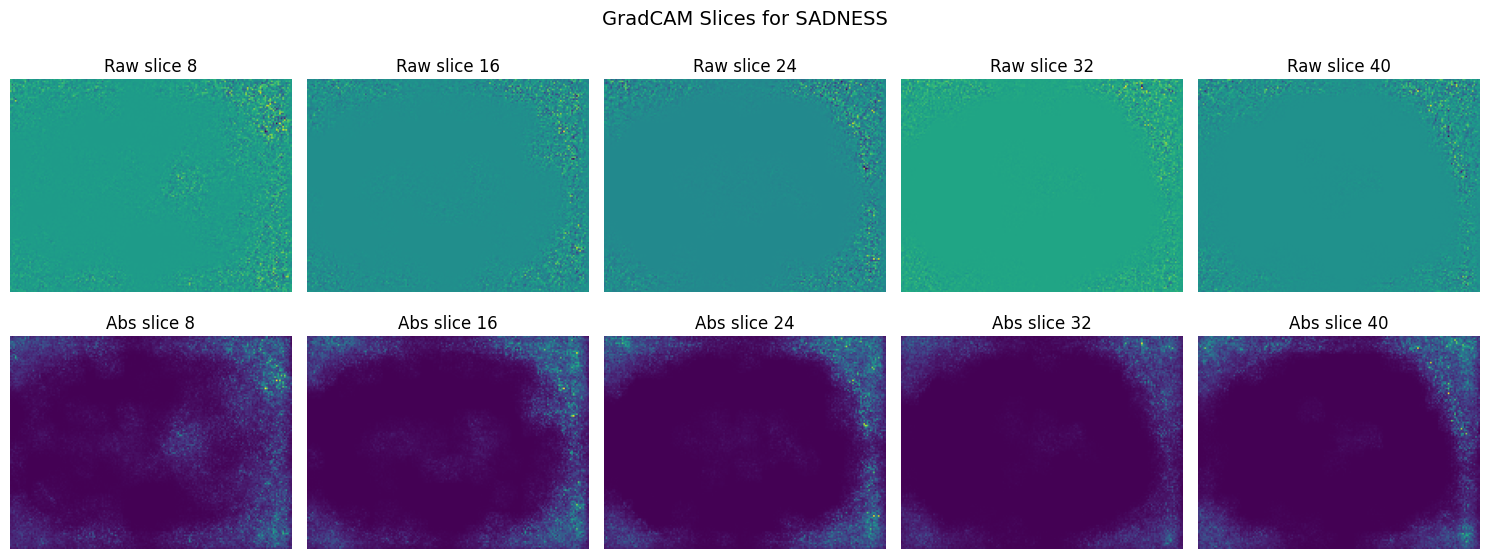

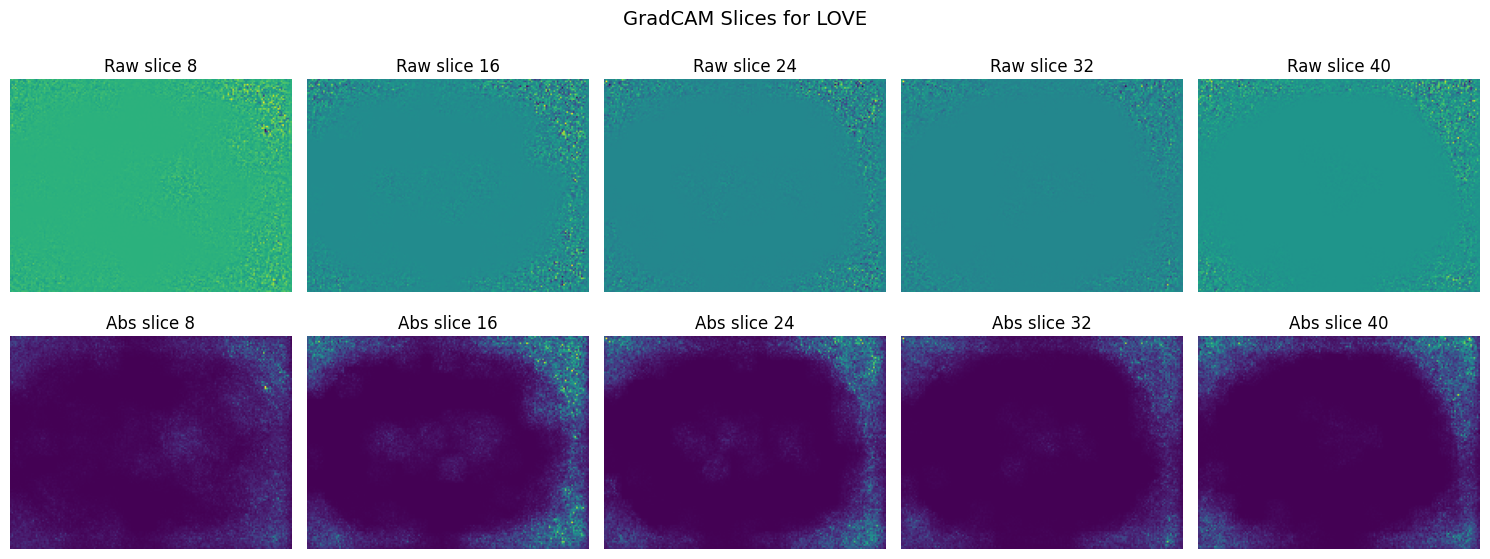

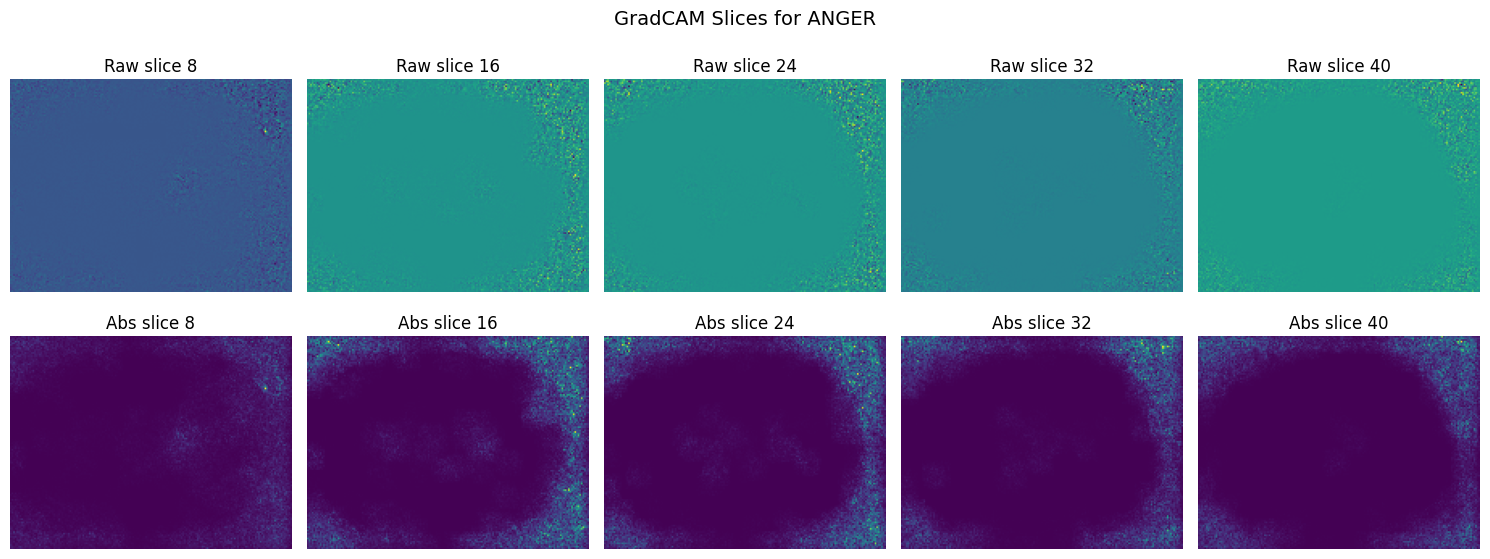

In [3]:
import torch
import pickle
import matplotlib.pyplot as plt
import os

# Load gradients
with open("/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl", "rb") as f:
    class_gradients = pickle.load(f)

# Map class index back to emotion names (swap keys/values)
idx_to_emotion = {v: k for k, v in cfg.data.emotion_idx.items() if k != "NONE"}

# Compute average (raw) gradients and average(|grad|) per class
class_avg_grad_raw = {k: v.mean(dim=0) for k, v in class_gradients.items()}
class_avg_grad_abs = {k: torch.abs(v).mean(dim=0) for k, v in class_gradients.items()}

# Decide which slices in the 3rd dimension (width) to plot.
# Here, we pick 5 roughly evenly spaced slices.
num_slices = 5

for class_idx in class_gradients.keys():
    emotion_name = idx_to_emotion.get(class_idx, f"Class {class_idx}")
    
    avg_raw = class_avg_grad_raw[class_idx].squeeze()    # → shape [D, H, W] if no channel
    avg_abs = class_avg_grad_abs[class_idx].squeeze()    # → same shape
    
    # If there's a channel dimension, drop it (e.g. [C, D, H, W])
    if avg_raw.dim() == 4:
        avg_raw = avg_raw[0]
        avg_abs = avg_abs[0]
    
    d, h, w = avg_raw.shape  # Typically [D, H, W]
    
    # Pick slice indices along the 3rd dimension (width)
    # For example, 5 evenly spaced slices
    slice_indices = [(w * (i + 1)) // (num_slices + 1) for i in range(num_slices)]
    
    # Create a figure with 2 rows (raw vs abs) and num_slices columns
    fig, axes = plt.subplots(nrows=2, ncols=num_slices, figsize=(3 * num_slices, 6))
    fig.suptitle(f"GradCAM Slices for {emotion_name}", fontsize=14)
    
    for col, s_idx in enumerate(slice_indices):
        raw_slice = avg_raw[:, :, s_idx].cpu().numpy()
        abs_slice = avg_abs[:, :, s_idx].cpu().numpy()
        
        ax_raw = axes[0, col]
        ax_abs = axes[1, col]
        
        ax_raw.imshow(raw_slice, cmap="viridis")
        ax_raw.set_title(f"Raw slice {s_idx}")
        ax_raw.axis("off")
        
        ax_abs.imshow(abs_slice, cmap="viridis")
        ax_abs.set_title(f"Abs slice {s_idx}")
        ax_abs.axis("off")
    
    plt.tight_layout()
    plt.show()


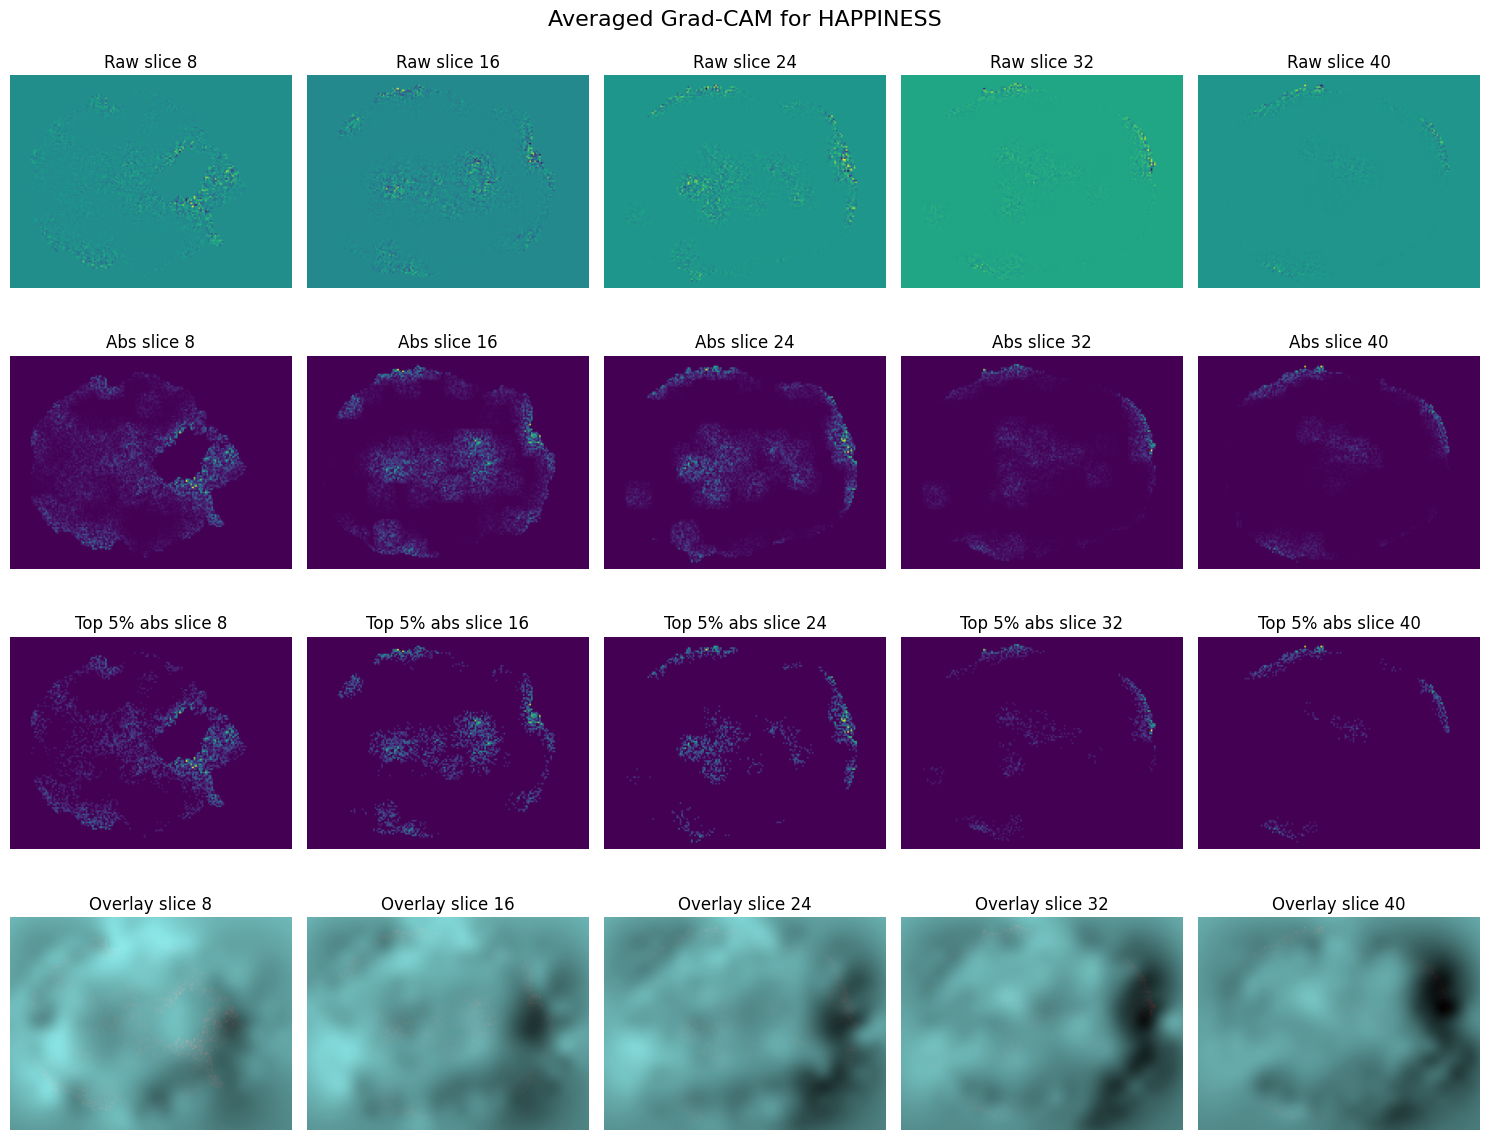

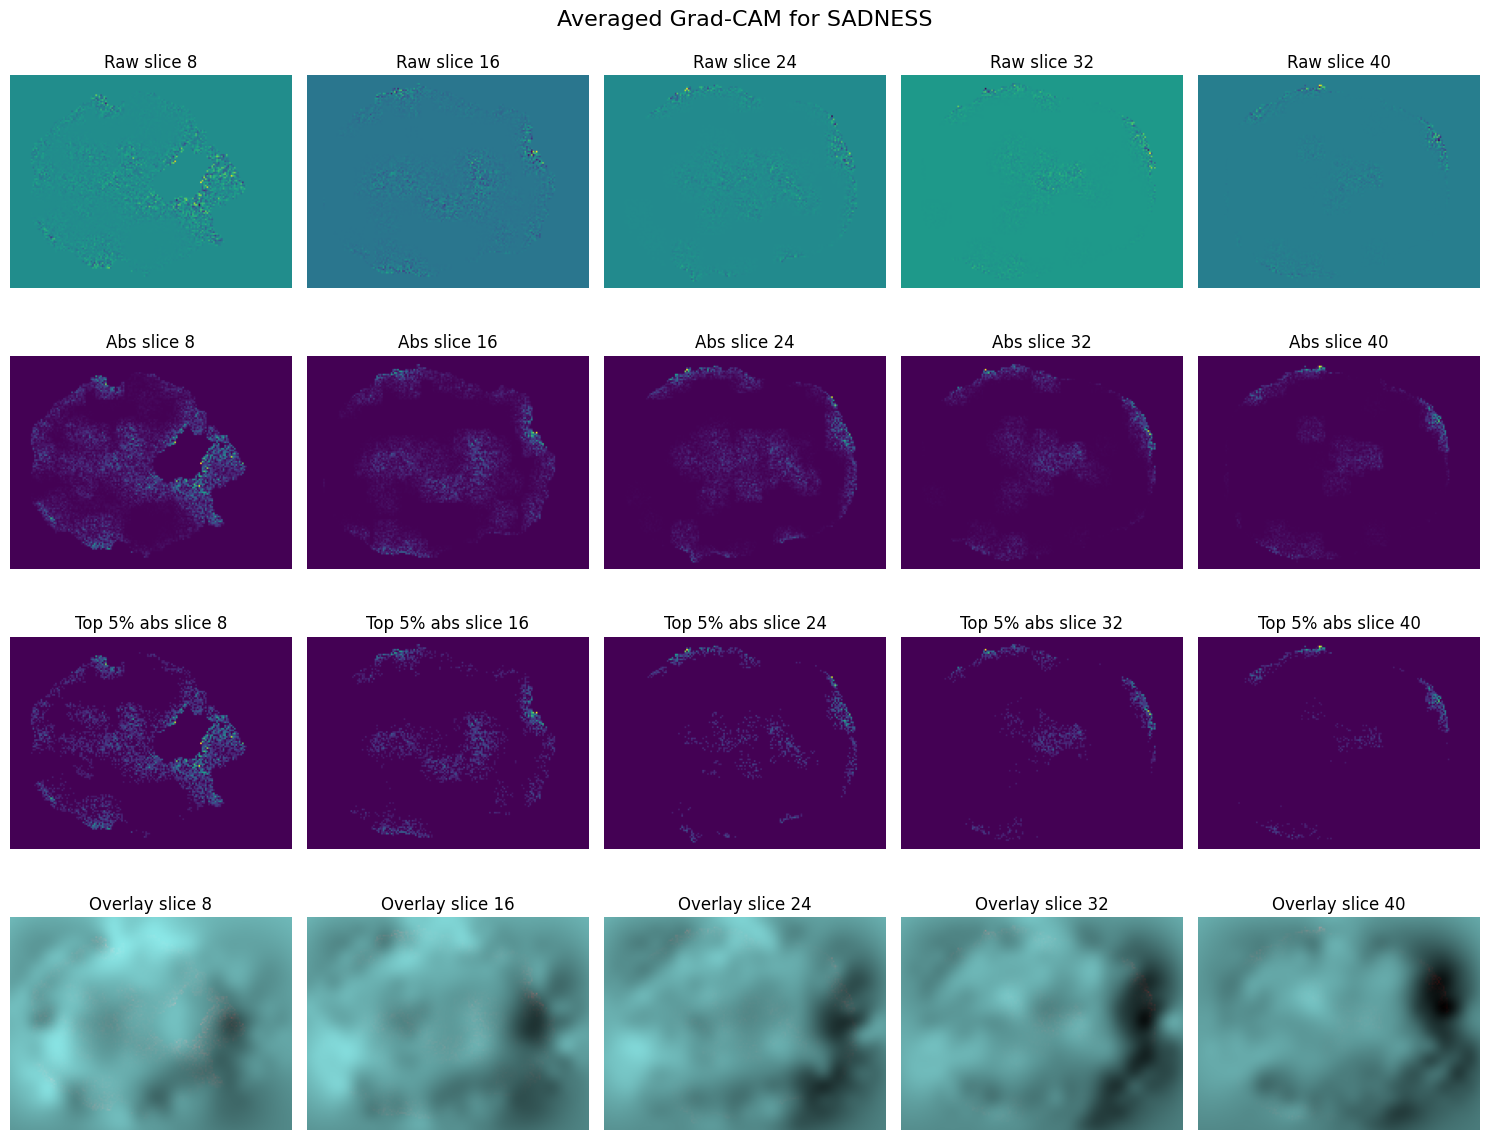

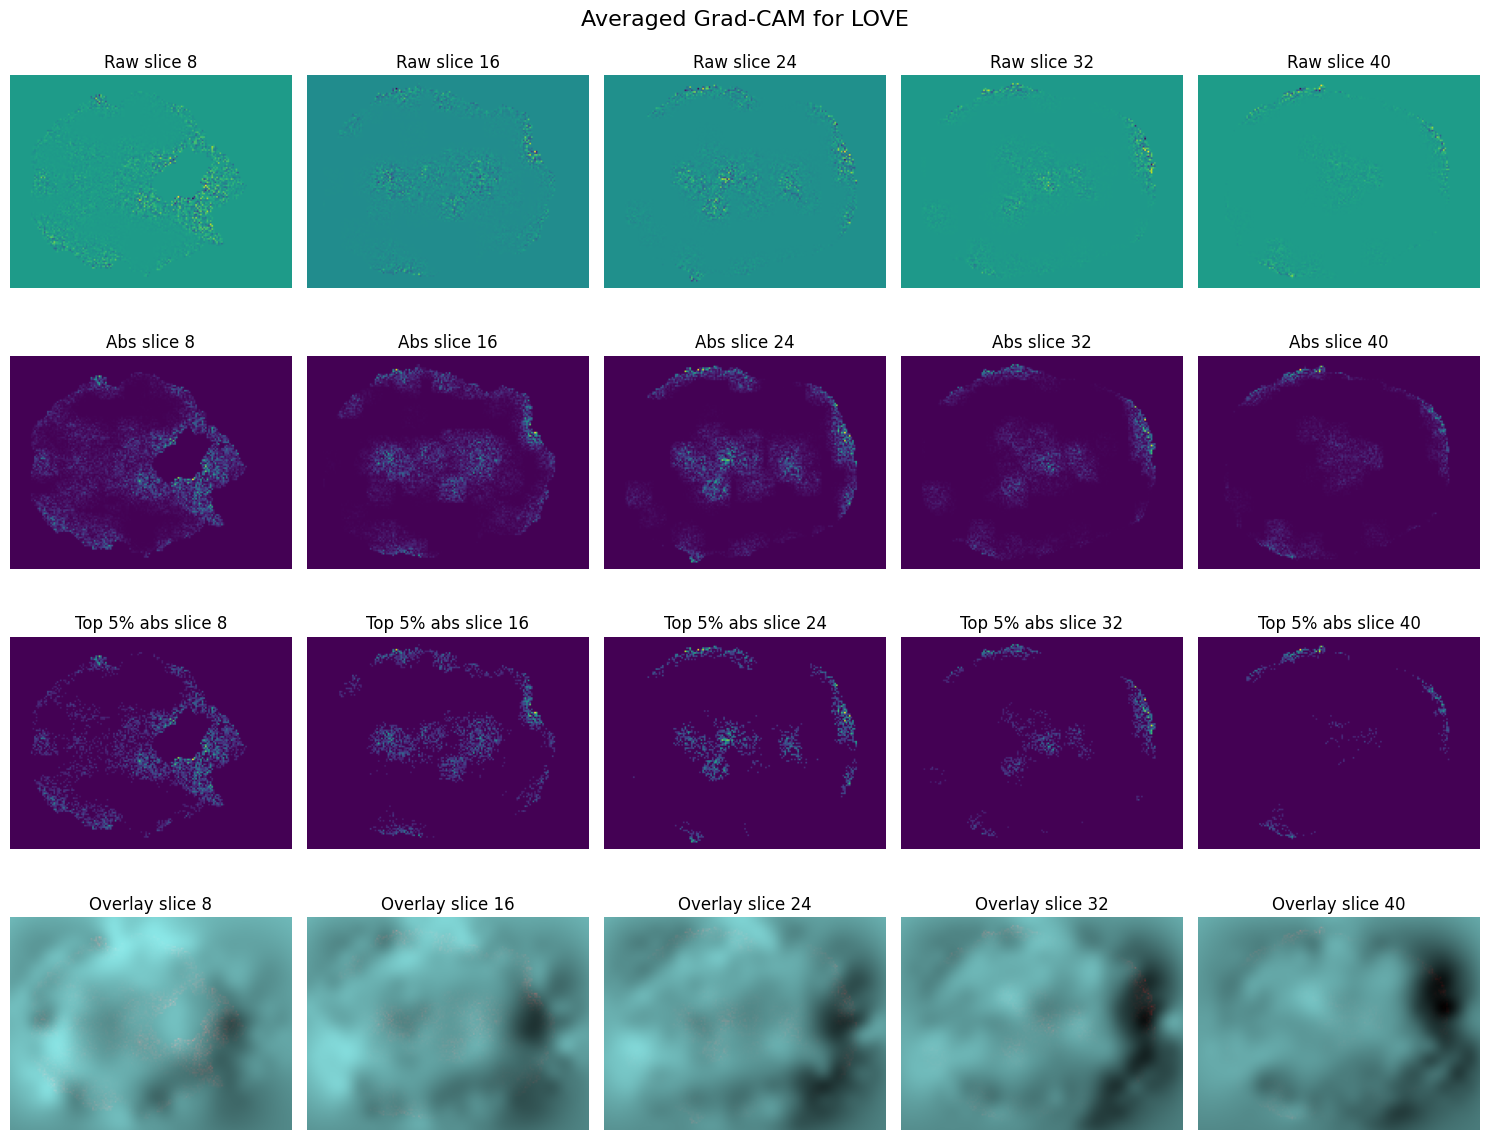

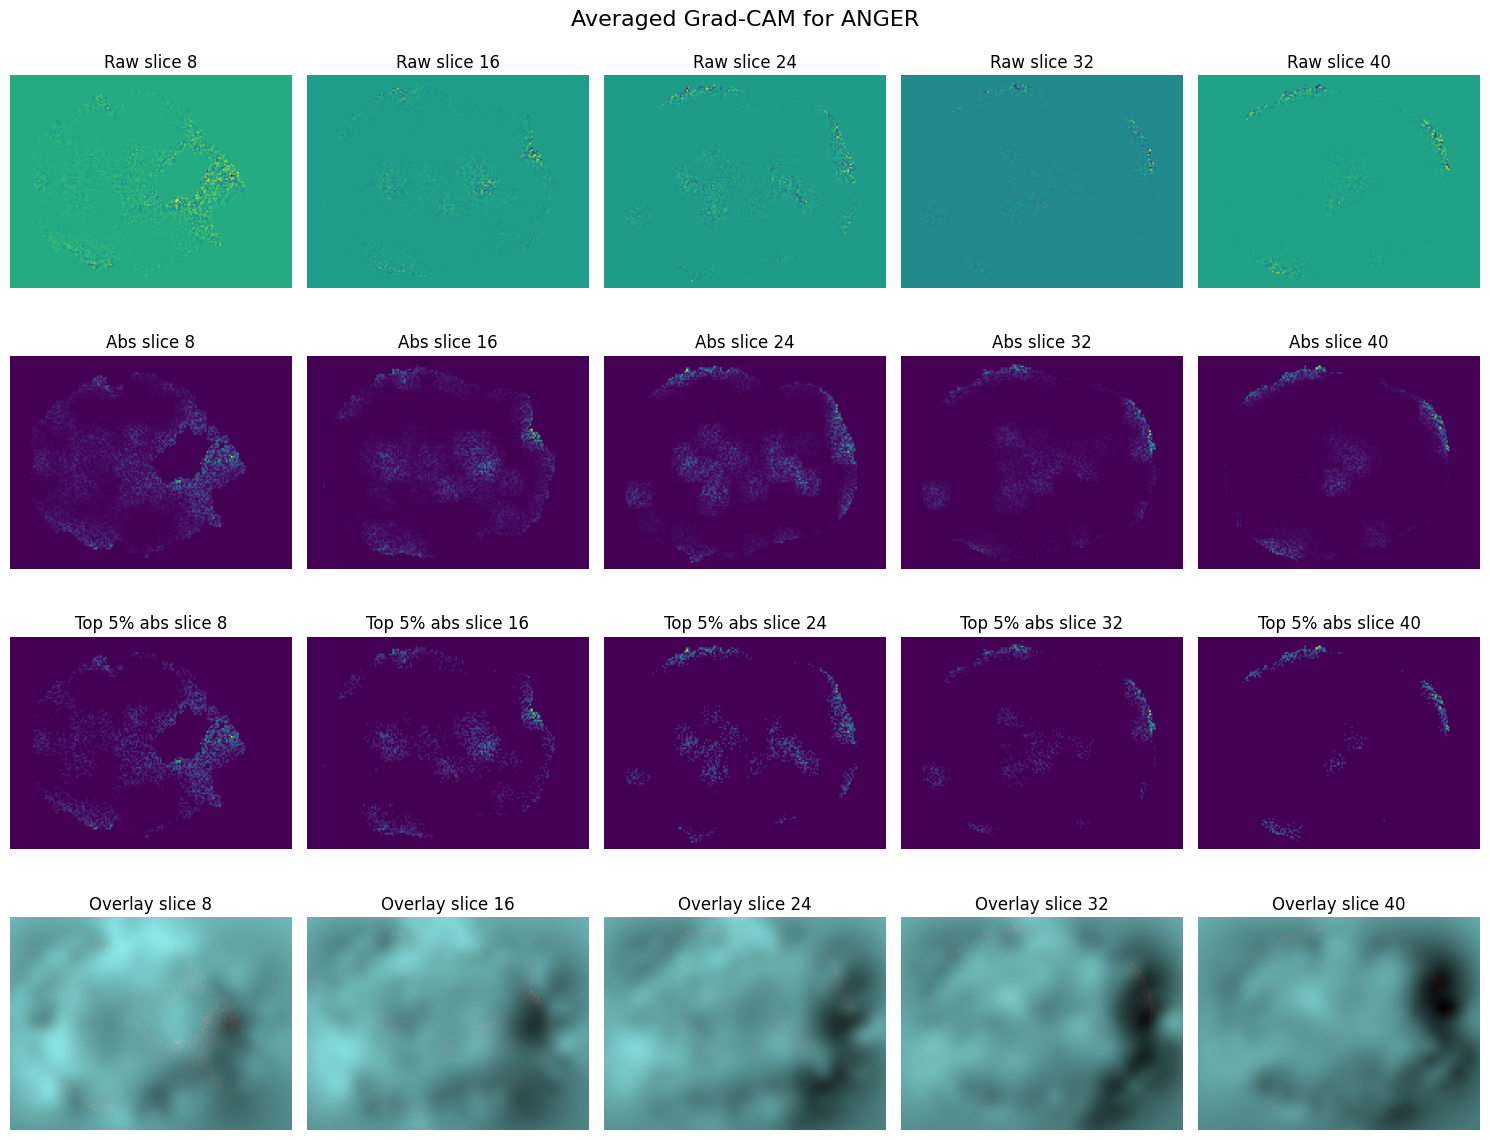

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#-------------------------------------------------------
# Config and paths
#-------------------------------------------------------
GRADCAM_PATH = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"
REFERENCE_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNLWarp_run-01_bold.nii.gz"
BRAIN_MASK_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadBrainMaskNLBrainMask_run-01_bold.nii.gz"

# Mapping from class indices to emotion names
idx_to_emotion = {0: "NONE", 1: "HAPPINESS", 2: "FEAR", 3: "SADNESS", 4: "LOVE", 5: "ANGER"}

#-------------------------------------------------------
# 1) Load Grad-CAM dictionary
#   class_gradients[class_idx] should be a list of 3D or 4D tensors per class
#-------------------------------------------------------
with open(GRADCAM_PATH, "rb") as f:
    class_gradients = pickle.load(f)

#-------------------------------------------------------
# 2) Prepare reference image (averaged across time if 4D)
#-------------------------------------------------------
ref_nii = nib.load(REFERENCE_PATH)
ref_data_4d = ref_nii.get_fdata()  # could be 3D or 4D
if ref_data_4d.ndim == 4:
    ref_data = ref_data_4d.mean(axis=-1)  # average across time → shape [Dx, Dy, Dz]
else:
    ref_data = ref_data_4d              # already 3D

ref_data_torch = torch.from_numpy(ref_data).float()

#-------------------------------------------------------
# 3) (Optional) Load a brain mask to zero out outside-brain voxels
#-------------------------------------------------------
mask_nii = nib.load(BRAIN_MASK_PATH)
mask_data = (mask_nii.get_fdata() > 0.5)
mask_torch = torch.from_numpy(mask_data).bool()

#-------------------------------------------------------
# Helper function: multiple slice Grad-CAM visualization
#-------------------------------------------------------
def visualize_3d_gradient(grad_3d, ref_3d, title="", x_percent=5, alpha=0.4, num_slices=5):
    """
    grad_3d: 3D PyTorch tensor [D, H, W], the gradient to visualize
    ref_3d:  3D PyTorch tensor [D, H, W], reference image for overlay
    title:   figure title
    x_percent: top X% threshold for abs(grad)
    alpha:   overlay alpha for blending
    num_slices: how many slices to show along the last dimension
    """
    grad_raw = grad_3d.clone()
    grad_abs = grad_raw.abs()

    # 1) Top X% threshold
    flat_abs = grad_abs.view(-1)
    threshold_val = torch.quantile(flat_abs, 1.0 - x_percent / 100.0)
    grad_thresh = grad_abs.clone()
    grad_thresh[grad_thresh < threshold_val] = 0.0

    # 2) Normalize for overlay
    grad_for_overlay = grad_abs.clone()
    gmin, gmax = grad_for_overlay.min(), grad_for_overlay.max()
    if gmax - gmin < 1e-9:
        grad_for_overlay *= 0
    else:
        grad_for_overlay = (grad_for_overlay - gmin) / (gmax - gmin)

    # 3) Normalize reference
    ref_for_display = ref_3d.clone()
    rmin, rmax = ref_for_display.min(), ref_for_display.max()
    ref_for_display = (ref_for_display - rmin) / max(rmax - rmin, 1e-9)

    d, h, w = grad_3d.shape  # assuming [D, H, W]
    slice_indices = [(w * (i+1)) // (num_slices+1) for i in range(num_slices)]

    fig, axes = plt.subplots(nrows=4, ncols=num_slices, figsize=(3 * num_slices, 12))
    fig.suptitle(title, fontsize=16)

    def normalize_slice(x):
        mn, mx = x.min(), x.max()
        return (x - mn) / (mx - mn + 1e-9)

    for col, s_idx in enumerate(slice_indices):
        # Extract slices
        sl_raw = grad_raw[:, :, s_idx].numpy()
        sl_abs = grad_abs[:, :, s_idx].numpy()
        sl_thresh = grad_thresh[:, :, s_idx].numpy()
        sl_ref = ref_for_display[:, :, s_idx].numpy()
        sl_overlay = grad_for_overlay[:, :, s_idx].numpy()

        # Normalize each slice for display
        sl_raw_norm = normalize_slice(sl_raw)
        sl_abs_norm = normalize_slice(sl_abs)
        sl_thresh_norm = normalize_slice(sl_thresh)

        # Row 0: raw
        axes[0, col].imshow(sl_raw_norm, cmap='viridis')
        axes[0, col].set_title(f"Raw slice {s_idx}")
        axes[0, col].axis("off")

        # Row 1: abs
        axes[1, col].imshow(sl_abs_norm, cmap='viridis')
        axes[1, col].set_title(f"Abs slice {s_idx}")
        axes[1, col].axis("off")

        # Row 2: threshold
        axes[2, col].imshow(sl_thresh_norm, cmap='viridis')
        axes[2, col].set_title(f"Top {x_percent}% abs slice {s_idx}")
        axes[2, col].axis("off")

        # Row 3: overlay
        overlay_rgb = np.stack([sl_ref, sl_ref, sl_ref], axis=-1)
        overlay_rgb[..., 0] = (1 - alpha) * overlay_rgb[..., 0] + alpha * sl_overlay
        axes[3, col].imshow(overlay_rgb)
        axes[3, col].set_title(f"Overlay slice {s_idx}")
        axes[3, col].axis("off")

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------
# 4) Main loop: average all gradients for each class
#    and visualize the result
#-------------------------------------------------------
for class_idx, grad_list in class_gradients.items():
    # Skip if empty
    if len(grad_list) == 0:
        continue

    # Stack and average. Each grad entry is either [C,D,H,W] or [D,H,W].
    # If you have single-tensor entries instead of a list, wrap in [ ] or debug as needed.
    avg_grad = grad_list.mean(dim=0)           # shape [C, D, H, W] or [D,H,W]

    # If there's a channel dimension, drop it.
    if avg_grad.dim() == 4:
        avg_grad = avg_grad[0]

    # Mask out outside brain if shapes match
    if mask_torch.shape == avg_grad.shape:
        avg_grad *= mask_torch

    # Use your emotion name mapping
    emotion_name = idx_to_emotion.get(class_idx, f"Class {class_idx}")
    fig_title = f"Averaged Grad-CAM for {emotion_name}"

    # 5) Visualize with top X% threshold, alpha overlay, etc.
    visualize_3d_gradient(
        grad_3d=avg_grad,
        ref_3d=ref_data_torch,
        title=fig_title,
        x_percent=5,  # top 5%
        alpha=0.4,
        num_slices=5
    )


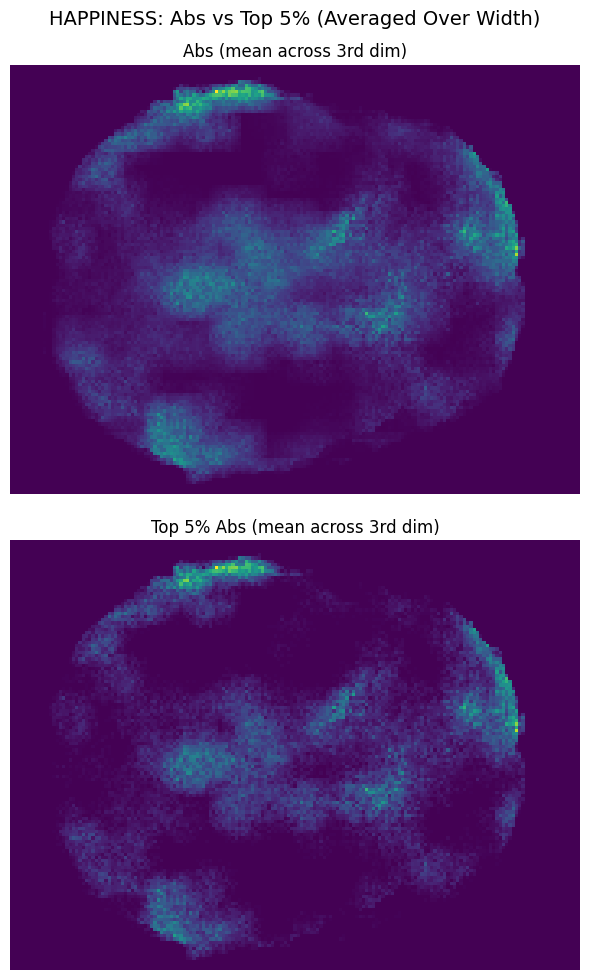

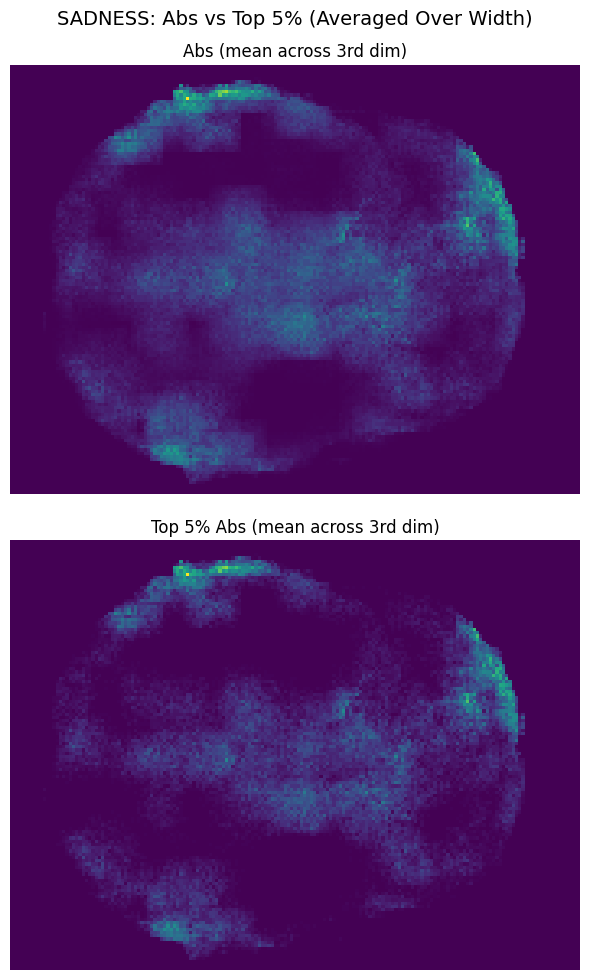

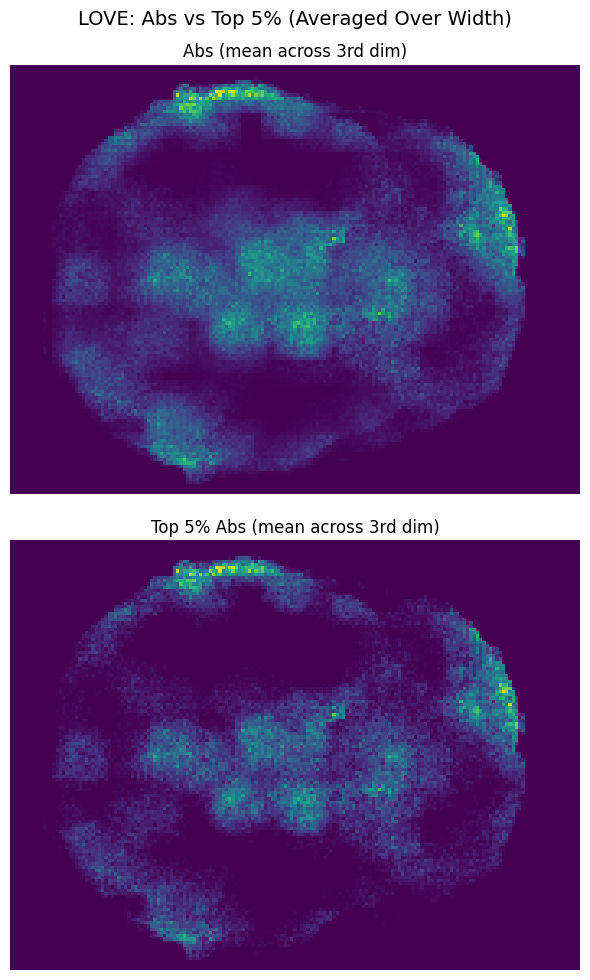

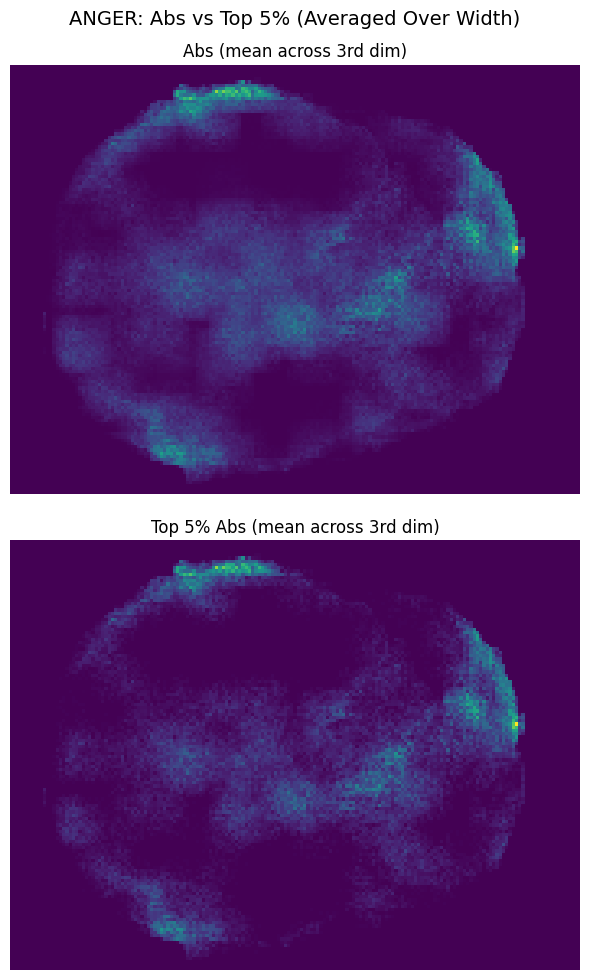

In [5]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#-------------------------------------------------------
# Config and paths
#-------------------------------------------------------
GRADCAM_PATH = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"
REFERENCE_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNLWarp_run-01_bold.nii.gz"
BRAIN_MASK_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadBrainMaskNLBrainMask_run-01_bold.nii.gz"

# Mapping from class indices to emotion names (optional)
idx_to_emotion = {0: "NONE", 1: "HAPPINESS", 2: "FEAR", 3: "SADNESS", 4: "LOVE", 5: "ANGER"}

#-------------------------------------------------------
# 1) Load Grad-CAM dictionary
#-------------------------------------------------------
with open(GRADCAM_PATH, "rb") as f:
    class_gradients = pickle.load(f)

#-------------------------------------------------------
# 2) Prepare reference image (if you need it for something else).
#   Not strictly used here because we won't do overlays now.
#-------------------------------------------------------
ref_nii = nib.load(REFERENCE_PATH)
ref_data_4d = ref_nii.get_fdata()
if ref_data_4d.ndim == 4:
    ref_data = ref_data_4d.mean(axis=-1)  # average across time
else:
    ref_data = ref_data_4d
ref_data_torch = torch.from_numpy(ref_data).float()

#-------------------------------------------------------
# 3) Load a brain mask (optional)
#-------------------------------------------------------
mask_nii = nib.load(BRAIN_MASK_PATH)
mask_data = (mask_nii.get_fdata() > 0.5)
mask_torch = torch.from_numpy(mask_data).bool()

#-------------------------------------------------------
# Main loop over each emotion class
#-------------------------------------------------------
for class_idx, grad_tensor in class_gradients.items():
    # If your storage is a single Tensor [N, D, H, W] instead of a list:
    #  - average across the first dimension
    # If it’s already an averaged single [D, H, W], skip the mean
    if grad_tensor.dim() == 4:
        # shape [N, D, H, W]
        avg_grad_3d = grad_tensor.mean(dim=0)  # [D, H, W]
    else:
        # shape [D, H, W] already
        avg_grad_3d = grad_tensor

    # (Optional) mask out outside brain
    if avg_grad_3d.shape == mask_torch.shape:
        avg_grad_3d *= mask_torch

    # 1) Absolute value
    grad_abs = avg_grad_3d.abs()

    # 2) Threshold top X% of abs
    X_percent = 5
    flat_abs = grad_abs.view(-1)
    thresh_val = torch.quantile(flat_abs, 1.0 - X_percent / 100.0)
    grad_thresh = grad_abs.clone()
    grad_thresh[grad_thresh < thresh_val] = 0.0

    # 3) Average over the 3rd dimension (width)
    #    So we go from [D, H, W] → [D, H] (assuming W is last dim)
    abs_avg_2d = grad_abs.mean(dim=2)
    thresh_avg_2d = grad_thresh.mean(dim=2)

    # Convert to NumPy for plotting
    abs_img = abs_avg_2d.cpu().numpy()
    thresh_img = thresh_avg_2d.cpu().numpy()

    # Plot just two rows:
    #   Row 0: abs (averaged across width)
    #   Row 1: top X% abs (averaged across width)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
    emotion_name = idx_to_emotion.get(class_idx, f"Class {class_idx}")
    fig.suptitle(f"{emotion_name}: Abs vs Top {X_percent}% (Averaged Over Width)", fontsize=14)

    # Row 0: abs
    axes[0].imshow(abs_img, cmap="viridis")
    axes[0].set_title("Abs (mean across 3rd dim)")
    axes[0].axis("off")

    # Row 1: top X% abs
    axes[1].imshow(thresh_img, cmap="viridis")
    axes[1].set_title(f"Top {X_percent}% Abs (mean across 3rd dim)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [6]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#-------------------------------------------------------
# Config
#-------------------------------------------------------
GRADCAM_PATH = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"
REFERENCE_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNLWarp_run-02_bold.nii.gz"
BRAIN_MASK_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadBrainMaskNLBrainMask_run-02_bold.nii.gz"

# Mapping from class indices to emotion names
idx_to_emotion = {0: "NONE", 1: "HAPPINESS", 2: "FEAR", 3: "SADNESS", 4: "LOVE", 5: "ANGER"}

#-------------------------------------------------------
# 1) Load Grad-CAM dictionary
#-------------------------------------------------------
with open(GRADCAM_PATH, "rb") as f:
    class_gradients = pickle.load(f)

#-------------------------------------------------------
# 2) Prepare reference image (averaging across time if 4D) – not strictly needed if we won't overlay
#-------------------------------------------------------
ref_nii = nib.load(REFERENCE_PATH)
ref_data_4d = ref_nii.get_fdata()
if ref_data_4d.ndim == 4:
    ref_data = ref_data_4d.mean(axis=-1)  
else:
    ref_data = ref_data_4d
ref_data_torch = torch.from_numpy(ref_data).float()

#-------------------------------------------------------
# 3) Load a brain mask (optional)
#-------------------------------------------------------
mask_nii = nib.load(BRAIN_MASK_PATH)
mask_data = (mask_nii.get_fdata() > 0.5)
mask_torch = torch.from_numpy(mask_data).bool()

#-------------------------------------------------------
# We'll collect exactly 5 classes' 2D average maps in a list
# (skipping "NONE" if it's class 0).
#-------------------------------------------------------
abs_imgs = []
titles = []

# We choose which class indices to visualize. For example, skip "NONE" (class 0) if you want exactly 5. 
class_indices_to_plot = [1, 2, 3, 4, 5]  # HAPPINESS, FEAR, SADNESS, LOVE, ANGER

for class_idx in class_indices_to_plot:
    grad_tensor = class_gradients[class_idx]
    
    # If shape is [N, D, H, W], average across samples
    if grad_tensor.dim() == 4:
        # shape [N, D, H, W]
        avg_grad_3d = grad_tensor.mean(dim=0)  # [D, H, W]
    else:
        # shape [D, H, W] already
        avg_grad_3d = grad_tensor

    # (Optional) apply the brain mask
    if avg_grad_3d.shape == mask_torch.shape:
        avg_grad_3d *= mask_torch

    # Compute absolute value
    grad_abs = avg_grad_3d.abs()

    # Average over the last dimension (width) → shape [D, H]
    abs_avg_2d = grad_abs.mean(dim=2)
    abs_img = abs_avg_2d.cpu().numpy()

    # Store in lists
    abs_imgs.append(abs_img)
    emotion_name = idx_to_emotion.get(class_idx, f"Class {class_idx}")
    titles.append(emotion_name)

#-------------------------------------------------------
# 4) Plot one figure with 5 subplots (1 row × 5 cols)
#-------------------------------------------------------
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax = axes[i]
    ax.imshow(abs_imgs[i], cmap="viridis")
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


KeyError: 2

In [7]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#-------------------------------------------------------
# Config
#-------------------------------------------------------
GRADCAM_PATH = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"
REFERENCE_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNLWarp_run-02_bold.nii.gz"
BRAIN_MASK_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadBrainMaskNLBrainMask_run-02_bold.nii.gz"

# Mapping from class indices to emotion names
idx_to_emotion = {0: "NONE", 1: "HAPPINESS", 2: "FEAR", 3: "SADNESS", 4: "LOVE", 5: "ANGER"}

# Which classes to visualize (skipping NONE=0)
class_indices_to_plot = [1, 2, 3, 4, 5]

#-------------------------------------------------------
# 1) Load Grad-CAM dictionary
#-------------------------------------------------------
with open(GRADCAM_PATH, "rb") as f:
    class_gradients = pickle.load(f)

#-------------------------------------------------------
# 2) (Optional) reference image and brain mask
#   We won't do an overlay here, but we load them for completeness.
#-------------------------------------------------------
ref_nii = nib.load(REFERENCE_PATH)
ref_data_4d = ref_nii.get_fdata()
if ref_data_4d.ndim == 4:
    ref_data = ref_data_4d.mean(axis=-1)  
else:
    ref_data = ref_data_4d
ref_data_torch = torch.from_numpy(ref_data).float()

mask_nii = nib.load(BRAIN_MASK_PATH)
mask_data = (mask_nii.get_fdata() > 0.5)
mask_torch = torch.from_numpy(mask_data).bool()

#-------------------------------------------------------
# 3) Compute per-class average gradient volumes
#    and also build a list of absolute-average-2D images.
#-------------------------------------------------------
avg_3d_volumes = []
abs_2d_imgs = []
titles = []

for class_idx in class_indices_to_plot:
    grad_tensor = class_gradients[class_idx]
    
    # If shape is [N, D, H, W], average across N
    if grad_tensor.dim() == 4:
        avg_3d = grad_tensor.mean(dim=0)  # now [D, H, W]
    else:
        avg_3d = grad_tensor  # already 3D

    # (Optional) mask out outside brain
    if avg_3d.shape == mask_torch.shape:
        avg_3d *= mask_torch

    # Absolute-value version
    grad_abs_3d = avg_3d.abs()
    # Average across the last dimension → [D, H]
    abs_2d = grad_abs_3d.mean(dim=2).cpu().numpy()

    avg_3d_volumes.append(avg_3d)
    abs_2d_imgs.append(abs_2d)
    titles.append(idx_to_emotion.get(class_idx, f"Class {class_idx}"))

#-------------------------------------------------------
# 4) Compute global average across these classes,
#    then subtract from each class to get "difference from mean".
#-------------------------------------------------------
stacked_vols = torch.stack(avg_3d_volumes, dim=0)  # shape [num_classes, D, H, W]
global_mean_3d = stacked_vols.mean(dim=0)          # shape [D, H, W]

diff_2d_imgs = []
for vol in avg_3d_volumes:
    diff_3d = vol - global_mean_3d
    diff_2d = diff_3d.mean(dim=2).cpu().numpy()  # shape [D, H]
    diff_2d_imgs.append(diff_2d)

#-------------------------------------------------------
# 5) We want one figure with 2 rows × len(classes) cols:
#    Row 0: absolute average
#    Row 1: difference from global mean
#-------------------------------------------------------
num_classes = len(class_indices_to_plot)
fig, axes = plt.subplots(nrows=2, ncols=num_classes, figsize=(4 * num_classes, 8))
fig.suptitle("Top: Abs-Averaged Gradients, Bottom: Difference from Mean", fontsize=16)

# For the difference row, let's unify color scaling so 0 is center
all_diffs = np.concatenate([d.flatten() for d in diff_2d_imgs])
min_val, max_val = all_diffs.min(), all_diffs.max()
bound = max(abs(min_val), abs(max_val))  # symmetric around zero

for i in range(num_classes):
    # Row 0: absolute map
    ax0 = axes[0, i]
    ax0.imshow(abs_2d_imgs[i], cmap="viridis")
    ax0.set_title(titles[i])
    ax0.axis("off")

    # Row 1: difference map (use RdBu or similar bipolar colormap)
    ax1 = axes[1, i]
    ax1.imshow(diff_2d_imgs[i], cmap="RdBu", vmin=-bound, vmax=bound)
    ax1.set_title(f"{titles[i]} - Mean")
    ax1.axis("off")

plt.tight_layout()
plt.show()


KeyError: 2

Skipping class 2, no gradients found.


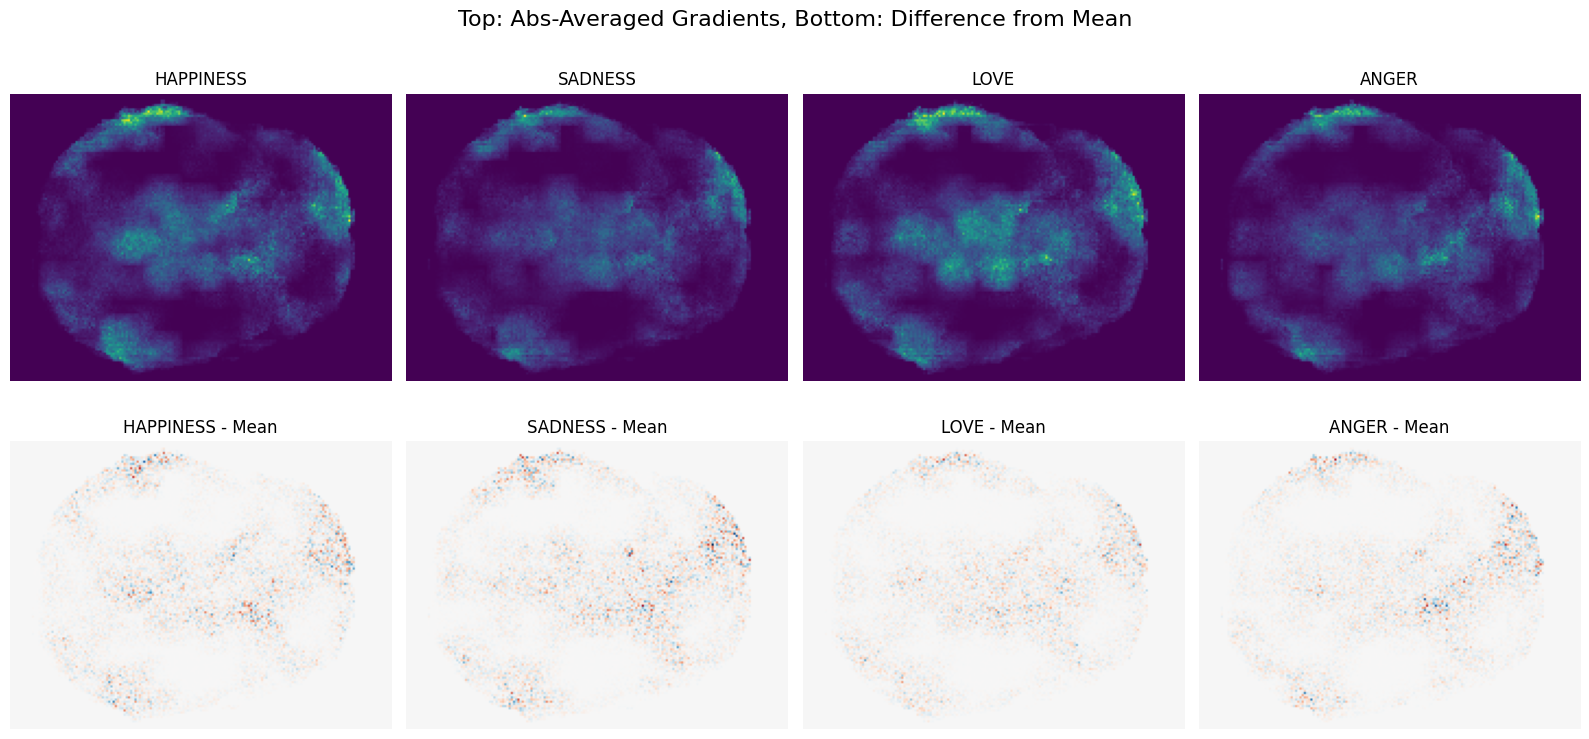

In [8]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#-------------------------------------------------------
# Config
#-------------------------------------------------------
GRADCAM_PATH = "/home/paperspace/DeepEmotion/output/Gradcam/class_gradients.pkl"
REFERENCE_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadNLWarp_run-02_bold.nii.gz"
BRAIN_MASK_PATH = "/home/paperspace/DeepEmotion/data/raw/derivatives/non-linear_anatomical_alignment/sub-01/ses-forrestgump/func/sub-01_ses-forrestgump_task-forrestgump_rec-dico7Tad2grpbold7TadBrainMaskNLBrainMask_run-02_bold.nii.gz"

# Mapping from class indices to emotion names
idx_to_emotion = {0: "NONE", 1: "HAPPINESS", 2: "FEAR", 3: "SADNESS", 4: "LOVE", 5: "ANGER"}

# Which classes to visualize
class_indices_to_plot = [1, 2, 3, 4, 5]  # skipping 0 (NONE)

#-------------------------------------------------------
# 1) Load Grad-CAM dictionary
#-------------------------------------------------------
with open(GRADCAM_PATH, "rb") as f:
    class_gradients = pickle.load(f)

#-------------------------------------------------------
# 2) Reference image and brain mask
#-------------------------------------------------------
ref_nii = nib.load(REFERENCE_PATH)
ref_data_4d = ref_nii.get_fdata()
if ref_data_4d.ndim == 4:
    ref_data = ref_data_4d.mean(axis=-1)  
else:
    ref_data = ref_data_4d
ref_data_torch = torch.from_numpy(ref_data).float()

mask_nii = nib.load(BRAIN_MASK_PATH)
mask_data = (mask_nii.get_fdata() > 0.5)
mask_torch = torch.from_numpy(mask_data).bool()

#-------------------------------------------------------
# 3) Compute per-class average gradient volumes
#-------------------------------------------------------
avg_3d_volumes = []
abs_2d_imgs = []
titles = []

for class_idx in class_indices_to_plot:
    if class_idx not in class_gradients:
        print(f"Skipping class {class_idx}, no gradients found.")
        continue

    grad_tensor = class_gradients[class_idx]
    
    # If shape is [N, D, H, W], average across N
    if grad_tensor.dim() == 4:
        avg_grad_3d = grad_tensor.mean(dim=0)  # [D, H, W]
    else:
        avg_grad_3d = grad_tensor  # already 3D

    # (Optional) mask out outside brain
    if avg_grad_3d.shape == mask_torch.shape:
        avg_grad_3d *= mask_torch

    # Absolute-value version
    grad_abs_3d = avg_grad_3d.abs()
    # Average across the last dimension → [D, H]
    abs_2d = grad_abs_3d.mean(dim=2).cpu().numpy()

    avg_3d_volumes.append(avg_grad_3d)
    abs_2d_imgs.append(abs_2d)
    titles.append(idx_to_emotion.get(class_idx, f"Class {class_idx}"))

if not avg_3d_volumes:
    print("No valid class gradients found to plot.")
else:
    #-------------------------------------------------------
    # 4) Compute global average across these classes,
    #    then subtract from each class to get "difference from mean".
    #-------------------------------------------------------
    stacked_vols = torch.stack(avg_3d_volumes, dim=0)  # shape [num_plotted, D, H, W]
    global_mean_3d = stacked_vols.mean(dim=0)          # shape [D, H, W]
    
    diff_2d_imgs = []
    for vol in avg_3d_volumes:
        diff_3d = vol - global_mean_3d
        diff_2d = diff_3d.mean(dim=2).cpu().numpy()  # shape [D, H]
        diff_2d_imgs.append(diff_2d)
    
    #-------------------------------------------------------
    # 5) Plot: top row = abs-averaged gradient, bottom row = difference
    #-------------------------------------------------------
    num_plotted = len(abs_2d_imgs)
    fig, axes = plt.subplots(nrows=2, ncols=num_plotted, figsize=(4 * num_plotted, 8))
    fig.suptitle("Top: Abs-Averaged Gradients, Bottom: Difference from Mean", fontsize=16)
    
    # For the difference row, unify color scaling so 0 is center
    all_diffs = np.concatenate([d.flatten() for d in diff_2d_imgs])
    min_val, max_val = all_diffs.min(), all_diffs.max()
    bound = max(abs(min_val), abs(max_val))  # symmetric around zero
    
    for i in range(num_plotted):
        # Row 0: absolute map
        ax0 = axes[0, i]
        ax0.imshow(abs_2d_imgs[i], cmap="viridis")
        ax0.set_title(titles[i])
        ax0.axis("off")
    
        # Row 1: difference map
        ax1 = axes[1, i]
        ax1.imshow(diff_2d_imgs[i], cmap="RdBu", vmin=-bound, vmax=bound)
        ax1.set_title(f"{titles[i]} - Mean")
        ax1.axis("off")
    
    plt.tight_layout()
    plt.show()
